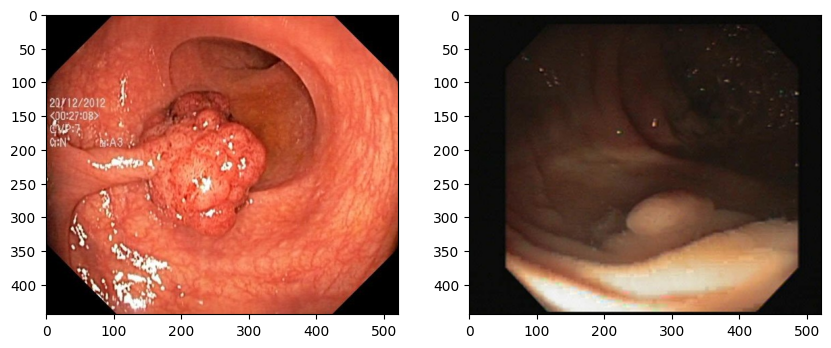

In [405]:
# import libs
import numpy as np
import cv2
import matplotlib.pyplot as plt

# read images
src = cv2.imread("src_medical.jpg")
trg = cv2.imread("trg_medical.jpg")

# resize trg to match src
trg = cv2.resize(trg, (src.shape[1], src.shape[0]))

# split into channels and reorder from BGR to RGB
srcB, srcG, srcR = cv2.split(src)
srcChannels = [srcR, srcG, srcB]
trgB, trgG, trgR = cv2.split(trg)
trgChannels = [trgR, trgG, trgB]

# show images
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.imshow(np.stack(srcChannels, axis=2))
plt.subplot(1, 2, 2)
plt.imshow(np.stack(trgChannels, axis=2))
plt.show()

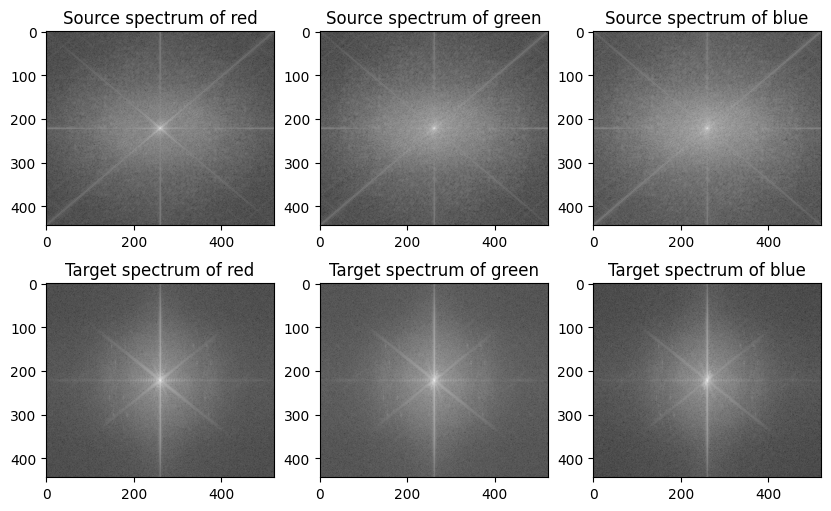

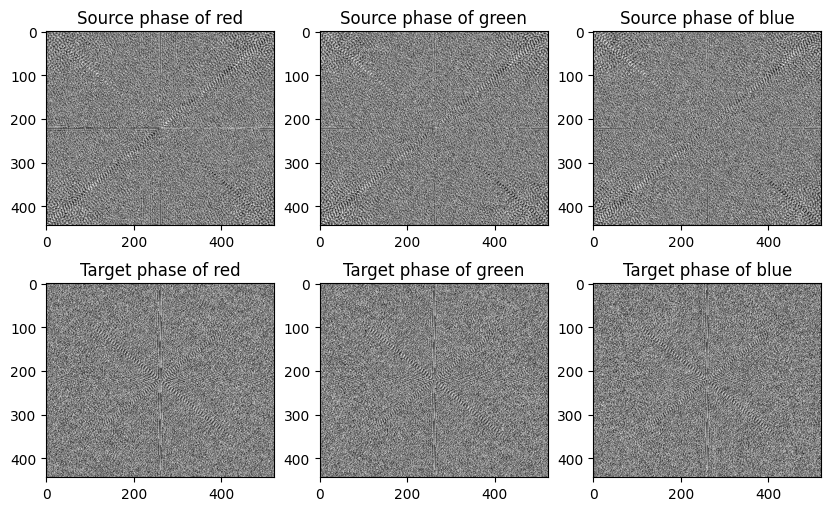

In [406]:
# calculate fourier transform, spectrum, phase
srcSpectrums = []
srcPhases = []
for srcChannel in srcChannels:
    # calculate fft and shift
    fft = np.fft.fft2(srcChannel)
    fft = np.fft.fftshift(fft)
    # calculate spectrum
    spec = np.abs(fft)
    srcSpectrums.append(spec)
    # calculate phase
    imag = np.imag(fft)
    real = np.real(fft)
    phase = np.arctan2(imag, real)
    srcPhases.append(phase)

trgSpectrums = []
trgPhases = []
for trgChannel in trgChannels:
    # calculate fft and shift
    fft = np.fft.fft2(trgChannel)
    fft = np.fft.fftshift(fft)
    # calculate spectrum
    spec = np.abs(fft)
    trgSpectrums.append(spec)
    # calculate phase
    imag = np.imag(fft)
    real = np.real(fft)
    phase = np.arctan2(imag, real)
    trgPhases.append(phase)

# show spectrums
plt.figure(figsize=(10, 6))
plt.subplot(2, 3, 1)
plt.imshow(np.log(srcSpectrums[0]), cmap="gray")
plt.title("Source spectrum of red")
plt.subplot(2, 3, 2)
plt.imshow(np.log(srcSpectrums[1]), cmap="gray")
plt.title("Source spectrum of green")
plt.subplot(2, 3, 3)
plt.imshow(np.log(srcSpectrums[2]), cmap="gray")
plt.title("Source spectrum of blue")
plt.subplot(2, 3, 4)
plt.imshow(np.log(trgSpectrums[0]), cmap="gray")
plt.title("Target spectrum of red")
plt.subplot(2, 3, 5)
plt.imshow(np.log(trgSpectrums[1]), cmap="gray")
plt.title("Target spectrum of green")
plt.subplot(2, 3, 6)
plt.imshow(np.log(trgSpectrums[2]), cmap="gray")
plt.title("Target spectrum of blue")
plt.show()

# show phases
plt.figure(figsize=(10, 6))
plt.subplot(2, 3, 1)
plt.imshow(srcPhases[0], cmap="gray")
plt.title("Source phase of red")
plt.subplot(2, 3, 2)
plt.imshow(srcPhases[1], cmap="gray")
plt.title("Source phase of green")
plt.subplot(2, 3, 3)
plt.imshow(srcPhases[2], cmap="gray")
plt.title("Source phase of blue")
plt.subplot(2, 3, 4)
plt.imshow(trgPhases[0], cmap="gray")
plt.title("Target phase of red")
plt.subplot(2, 3, 5)
plt.imshow(trgPhases[1], cmap="gray")
plt.title("Target phase of green")
plt.subplot(2, 3, 6)
plt.imshow(trgPhases[2], cmap="gray")
plt.title("Target phase of blue")
plt.show()




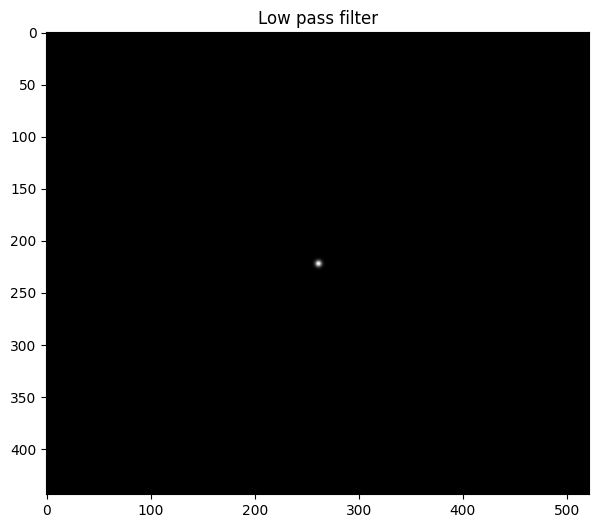

In [407]:
# create gaussian low pass filter
def gaussianLowPassFilter(shape, sigma):
    # create gaussian filter
    filtered = np.zeros(shape)
    center = (shape[0] // 2, shape[1] // 2)
    for i in range(shape[0]):
        for j in range(shape[1]):
            filtered[i, j] = np.exp(-((i - center[0]) ** 2 + (j - center[1]) ** 2) / (2 * sigma ** 2))
    return filtered

lowpass = gaussianLowPassFilter(srcSpectrums[0].shape, 2.2)

# show low pass filter
plt.figure(figsize=(10, 6))
plt.imshow(lowpass, cmap="gray")
plt.title("Low pass filter")
plt.show()

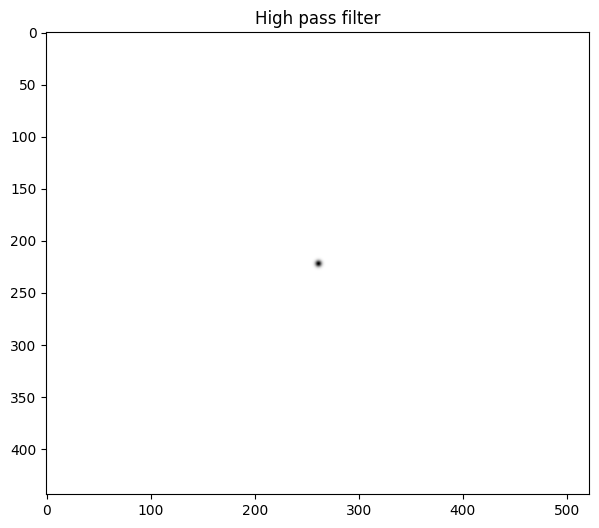

In [408]:
# create high pass by making low pass filter negative
highpass = 1 - lowpass

# show high pass filter
plt.figure(figsize=(10, 6))
plt.imshow(highpass, cmap="gray")
plt.title("High pass filter")
plt.show()

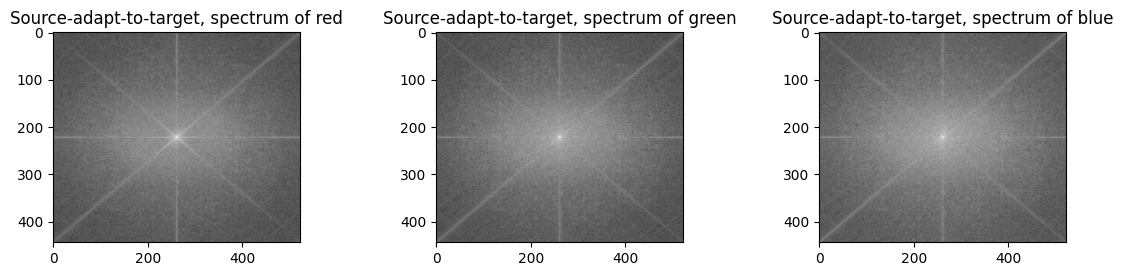

In [409]:
# get blended = srcSpec * highpass +  trgSpec * lowpass
# do elementwise multiplication
blendedSpectrums = []
for i in range(3):
    blendedSpectrum = srcSpectrums[i] * highpass + trgSpectrums[i] * lowpass
    blendedSpectrums.append(blendedSpectrum)

# show blended spectrums
plt.figure(figsize=(14, 6))
plt.subplot(2, 3, 1)
plt.imshow(np.log(blendedSpectrums[0]), cmap="gray")
plt.title("Source-adapt-to-target, spectrum of red")
plt.subplot(2, 3, 2)
plt.imshow(np.log(blendedSpectrums[1]), cmap="gray")
plt.title("Source-adapt-to-target, spectrum of green")
plt.subplot(2, 3, 3)
plt.imshow(np.log(blendedSpectrums[2]), cmap="gray")
plt.title("Source-adapt-to-target, spectrum of blue")
plt.show()

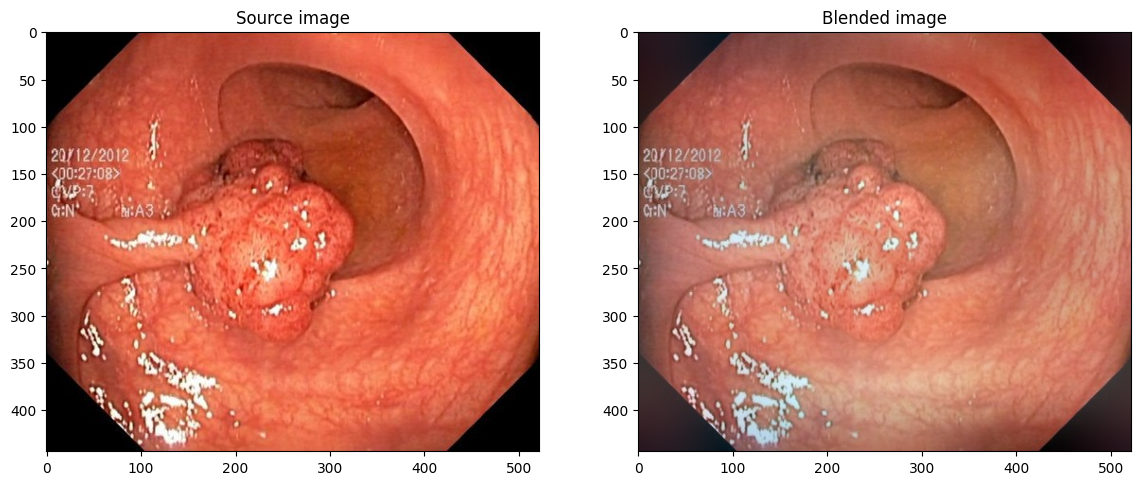

In [410]:
blendedChannels = []
for i in range(3):
    # get spectrum |G(u,v)|
    spec = blendedSpectrums[i]
    # get phase phi_src(u,v)
    phase = srcPhases[i]
    # elementwise multiplication
    fft = spec * np.exp(1j * phase)
    # shift back
    fft = np.fft.ifftshift(fft)
    # inverse fft
    ifft = np.fft.ifft2(fft)
    # get real part
    ifft = np.real(ifft)
    # normalize
    ifft = (ifft - np.min(ifft)) / (np.max(ifft) - np.min(ifft))
    blendedChannels.append(ifft)

# merge and show blended image with original image
blendedImage = np.stack(blendedChannels, axis=2)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.stack(srcChannels, axis=2))
plt.title("Source image")
plt.subplot(1, 2, 2)
plt.imshow(blendedImage)
plt.title("Blended image")
plt.show()